In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Load and Prepare the Dataset
file_path = 'Dates Active Power Load - 33_11KV - Godishala Substation.csv'
data = pd.read_csv(file_path)

In [5]:
data

,DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0
0,01-01-2021,01-00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Nov-Feb,Winter,1.0
1,01-01-2021,02-00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,Mar-Jun,Summer,2.0
2,01-01-2021,03-00,11.6,102,0.96,1967,0,1,65,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01-01-2021,04-00,11.3,130,0.96,2443,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekend,1,NaN
4,01-01-2021,05-00,11.2,148,0.96,2756,0,1,78,49,NaN,NaN,NaN,NaN,NaN,Weekday,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,31-12-2021,20-00,11.6,64,0.95,1222,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8756,31-12-2021,21-00,11.5,62,0.95,1173,0,1,67,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8757,31-12-2021,22-00,11.5,57,0.95,1079,0,1,65,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8758,31-12-2021,23-00,11.5,48,0.95,908,0,1,65,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Handle missing values
data.fillna(0, inplace=True)

In [7]:
data.head()

,DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0
0,01-01-2021,01-00,11.6,102,0.96,1967,0,1,65,90,0.0,0.0,0.0,0.0,0.0,Nov-Feb,Winter,1.0
1,01-01-2021,02-00,11.6,102,0.96,1967,0,1,65,90,0.0,0.0,0.0,0.0,0.0,Mar-Jun,Summer,2.0
2,01-01-2021,03-00,11.6,102,0.96,1967,0,1,65,90,0.0,0.0,0.0,0.0,0.0,0,0,0.0
3,01-01-2021,04-00,11.3,130,0.96,2443,0,1,78,49,0.0,0.0,0.0,0.0,0.0,Weekend,1,0.0
4,01-01-2021,05-00,11.2,148,0.96,2756,0,1,78,49,0.0,0.0,0.0,0.0,0.0,Weekday,0,0.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 8760 non-null   object 
 1   TIME                 8760 non-null   object 
 2   VOLTAGE              8760 non-null   float64
 3   CURRENT              8760 non-null   int64  
 4   PF                   8760 non-null   float64
 5   POWER (KW)           8760 non-null   int64  
 6   "WEEKEND/WEEKDAY"    8760 non-null   int64  
 7   SEASON               8760 non-null   int64  
 8   Temp (F)             8760 non-null   int64  
 9   Humidity (%)         8760 non-null   int64  
 10  Substation Shutdown  8760 non-null   float64
 11  F1                   8760 non-null   float64
 12  F2                   8760 non-null   float64
 13  F3                   8760 non-null   float64
 14  F4                   8760 non-null   float64
 15  Jul-Oct-             8760 non-null   o

In [9]:
data.describe()

,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,0
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.00000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,11.550228,114.802854,0.929584,2129.986758,0.142466,0.99726,81.184132,67.726712,0.007534,0.002854,0.008105,0.011073,0.005251,0.000342
std,0.179907,69.966107,0.058151,1302.279873,0.349547,0.81933,8.881827,20.684501,0.086477,0.053348,0.089667,0.104650,0.072278,0.023890
min,11.000000,21.000000,0.690000,412.000000,0.000000,0.00000,50.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.400000,56.750000,0.900000,1063.000000,0.000000,0.00000,76.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.600000,92.000000,0.960000,1683.500000,0.000000,1.00000,81.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11.700000,164.000000,0.970000,3026.000000,0.000000,2.00000,86.000000,87.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,379.000000,1.000000,6306.000000,1.000000,2.00000,108.000000,102.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [10]:
data.columns

Index(['DATE', 'TIME', 'VOLTAGE', 'CURRENT', 'PF', 'POWER (KW)',
       '"WEEKEND/WEEKDAY"', 'SEASON', 'Temp (F)', 'Humidity (%)',
       'Substation Shutdown', 'F1', 'F2', 'F3', 'F4', 'Jul-Oct-', 'Rainy',
       '0'],
      dtype='object')

In [11]:
data.dtypes

DATE                    object
TIME                    object
VOLTAGE                float64
CURRENT                  int64
PF                     float64
POWER (KW)               int64
"WEEKEND/WEEKDAY"        int64
SEASON                   int64
Temp (F)                 int64
Humidity (%)             int64
Substation Shutdown    float64
F1                     float64
F2                     float64
F3                     float64
F4                     float64
Jul-Oct-                object
Rainy                   object
0                      float64
dtype: object

In [12]:

# Encode Categorical Features
enc = LabelEncoder()
data['F1'] = enc.fit_transform(data['F2'])
data['F2'] = enc.fit_transform(data['F2'])
data['F3'] = enc.fit_transform(data['F3'])
data['F4'] = enc.fit_transform(data['F4'])
data['Substation Shutdown'] = enc.fit_transform(data['Substation Shutdown'])

In [13]:
# Convert DATE to datetime format
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y')
data['DAY'] = data['DATE'].dt.day
data['MONTH'] = data['DATE'].dt.month
data['HOUR'] = pd.to_datetime(data['TIME'], format='%H-%M').dt.hour

In [14]:
# Drop unused columns
data.drop(['DATE', 'TIME', 'Jul-Oct-', 'Rainy', '0'], axis=1, inplace=True)


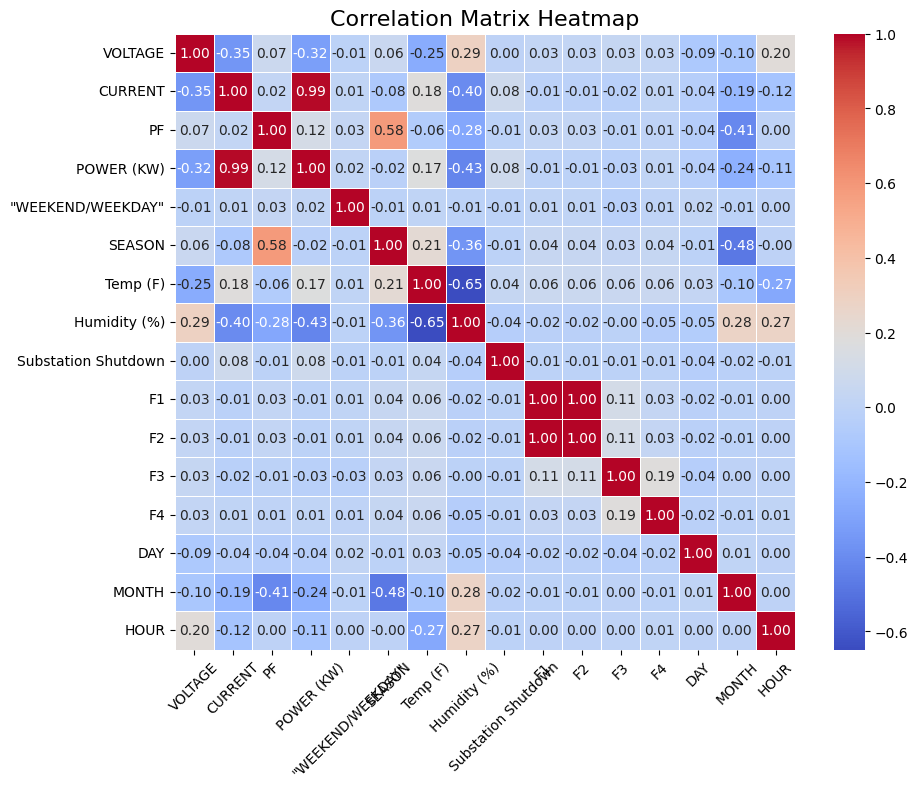

In [15]:
# Visualize the correlation matrix
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.show()


In [16]:
# Prepare Features and Target
features = data.drop('POWER (KW)', axis=1)
target = data['POWER (KW)']

# Normalize features and target
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))


In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.3, random_state=42)

# Reshape the data for LSTM and GRU (samples, timesteps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test_actual = y_test 

In [18]:
# Build and Train the LSTM Model
model_lstm = Sequential([
    LSTM(units=30, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.6),
    LSTM(units=30, return_sequences=False),
    Dropout(0.6),
    Dense(units=1)
])
model_lstm.compile(optimizer=AdamW(learning_rate=0.0003), loss='mean_squared_error')
history_lstm = model_lstm.fit(X_train_reshaped, y_train, epochs=7, batch_size=32, validation_data=(X_test_reshaped, y_test))


Epoch 1/7
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1025 - val_loss: 0.0487
Epoch 2/7
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0512 - val_loss: 0.0389
Epoch 3/7
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0416 - val_loss: 0.0236
Epoch 4/7
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0268 - val_loss: 0.0102
Epoch 5/7
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - val_loss: 0.0064
Epoch 6/7
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0048
Epoch 7/7
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - val_loss: 0.0044


In [19]:
model_lstm.save('lstm_model.h5')
print("LSTM model saved as 'lstm_model.h5'")


LSTM model saved as 'lstm_model.h5'


In [20]:
def evaluate_model(model, X_test_reshaped, y_test_actual):
    y_pred_scaled = model.predict(X_test_reshaped)
    y_pred = scaler_target.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_target.inverse_transform(y_test_actual)
    
    r2 = r2_score(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    mae = mean_absolute_error(y_test_actual, y_pred)
    rmse = math.sqrt(mse)
    
    return r2, mse, mae, rmse, y_pred

# LSTM Evaluation
r2_lstm, mse_lstm, mae_lstm, rmse_lstm, y_pred_lstm = evaluate_model(model_lstm, X_test_reshaped, y_test)
print("LSTM Performance:")
print(f'R2 Score: {r2_lstm}, MSE: {mse_lstm}, MAE: {mae_lstm}, RMSE: {rmse_lstm}')

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Performance:
R2 Score: 0.9115261295665628, MSE: 153035.3413992038, MAE: 296.7601267032245, RMSE: 391.19731773007317


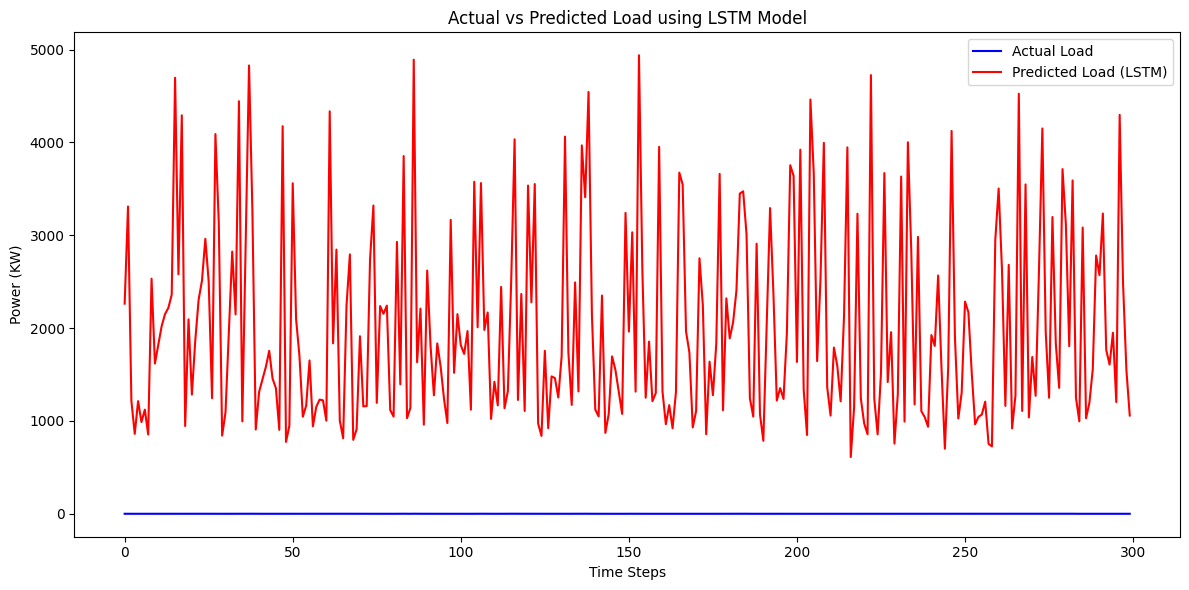

In [21]:
# Cell: Plot Actual vs Predicted for LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:300], label='Actual Load', color='blue', linestyle='-', linewidth=1.5)
plt.plot(y_pred_lstm[:300], label='Predicted Load (LSTM)', color='red', linestyle='-', linewidth=1.5)

# Add labels, title, and legend
plt.xlabel('Time Steps')
plt.ylabel('Power (KW)')
plt.title('Actual vs Predicted Load using LSTM Model')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [22]:
# Build and Train the GRU Model
model_gru = Sequential([
    GRU(units=30, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.6),
    GRU(units=30, return_sequences=False),
    Dropout(0.6),
    Dense(units=1)
])
model_gru.compile(optimizer=AdamW(learning_rate=0.0003), loss='mean_squared_error')
history_gru = model_gru.fit(X_train_reshaped, y_train, epochs=5, batch_size=30, validation_data=(X_test_reshaped, y_test))


Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0877 - val_loss: 0.0386
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0476 - val_loss: 0.0244
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0313 - val_loss: 0.0134
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0244 - val_loss: 0.0085
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0203 - val_loss: 0.0056


In [23]:
model_gru.save('gru_model.h5')
print("GRU model saved as 'gru_model.h5'")


GRU model saved as 'gru_model.h5'


In [24]:
# Evaluate Model
def evaluate_model(model, X_test_reshaped, y_test_actual):
    y_pred_scaled = model.predict(X_test_reshaped)
    y_pred = scaler_target.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_target.inverse_transform(y_test_actual)
    
    r2 = r2_score(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    mae = mean_absolute_error(y_test_actual, y_pred)
    rmse = math.sqrt(mse)
    
    return r2, mse, mae, rmse, y_pred
    
# GRU Evaluation
r2_gru, mse_gru, mae_gru, rmse_gru, y_pred_gru = evaluate_model(model_gru, X_test_reshaped, y_test)
print("\nGRU Performance:")
print(f'R2 Score: {r2_gru}, MSE: {mse_gru}, MAE: {mae_gru}, RMSE: {rmse_gru}')
 

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

GRU Performance:
R2 Score: 0.8872908711825382, MSE: 194955.63970340695, MAE: 349.3866977314244, RMSE: 441.5378123144234


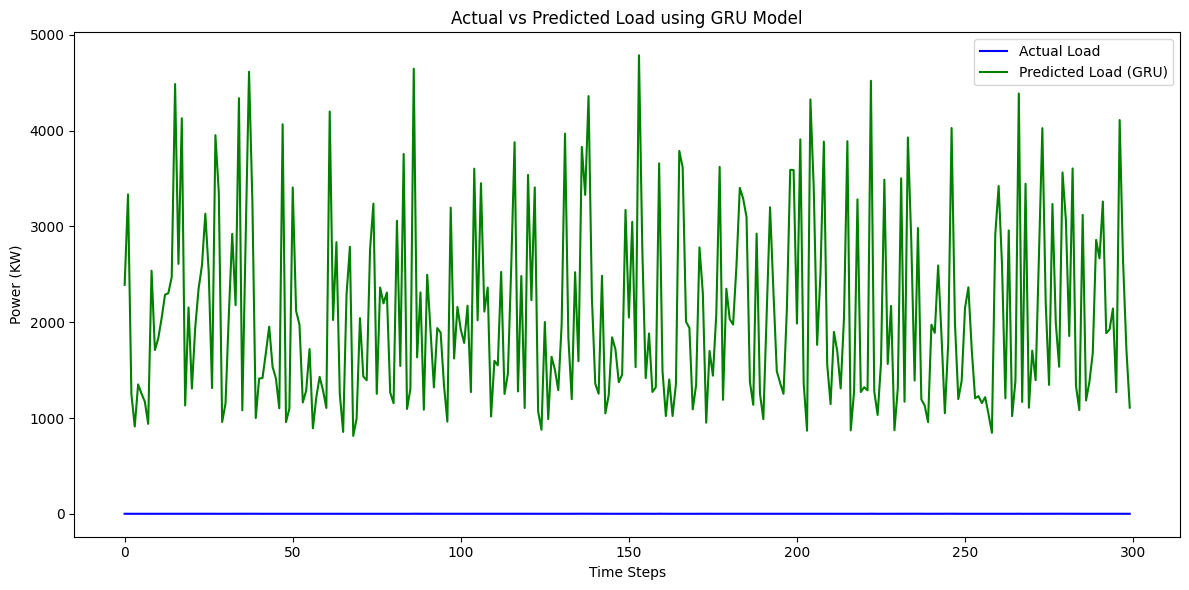

In [25]:
# Cell: Plot Actual vs Predicted for GRU
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:300], label='Actual Load', color='blue', linestyle='-', linewidth=1.5)
plt.plot(y_pred_gru[:300], label='Predicted Load (GRU)', color='green', linestyle='-', linewidth=1.5)

# Add labels, title, and legend
plt.xlabel('Time Steps')
plt.ylabel('Power (KW)')
plt.title('Actual vs Predicted Load using GRU Model')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [26]:
# Compare Performance
comparison_df = pd.DataFrame({
    'Metric': ['R2 Score', 'MSE', 'MAE', 'RMSE'],
    'LSTM': [r2_lstm, mse_lstm, mae_lstm, rmse_lstm],
    'GRU': [r2_gru, mse_gru, mae_gru, rmse_gru]
})
print("\nComparison of LSTM and GRU Performance:")
print(comparison_df)



Comparison of LSTM and GRU Performance:
     Metric           LSTM            GRU
0  R2 Score       0.911526       0.887291
1       MSE  153035.341399  194955.639703
2       MAE     296.760127     349.386698
3      RMSE     391.197318     441.537812


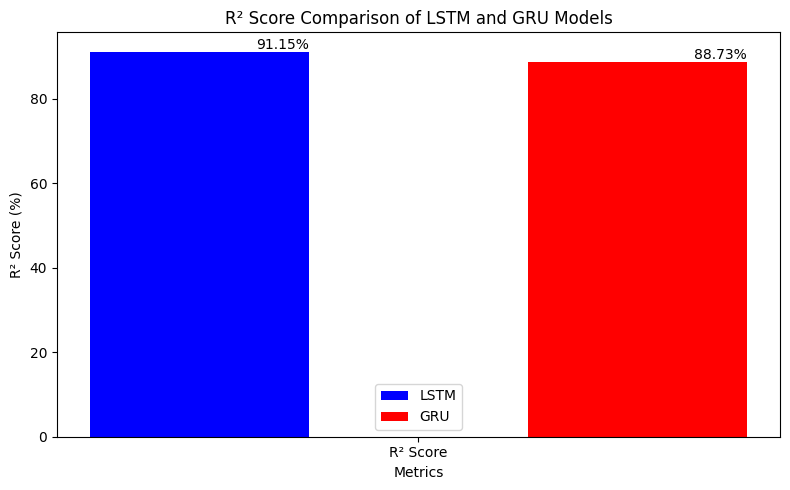

In [27]:
# Prepare data for R² Score comparison
metrics = ['R² Score']
lstm_metrics = [r2_lstm * 100]  # Convert R² score to percentage
gru_metrics = [r2_gru * 100]    # Convert R² score to percentage

# Set up the bar locations and width
x = np.arange(len(metrics))  # the label locations
width = 0.2  # Set the width of each bar (medium width)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Create bars for LSTM and GRU with larger spacing between them
bars1 = ax.bar(x - width, lstm_metrics, width, label='LSTM', color='blue')
bars2 = ax.bar(x + width, gru_metrics, width, label='GRU', color='red')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('R² Score (%)')
ax.set_title('R² Score Comparison of LSTM and GRU Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top-right of the bars
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width(), yval, f'{round(yval, 2)}%', va='bottom', ha='right')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width(), yval, f'{round(yval, 2)}%', va='bottom', ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


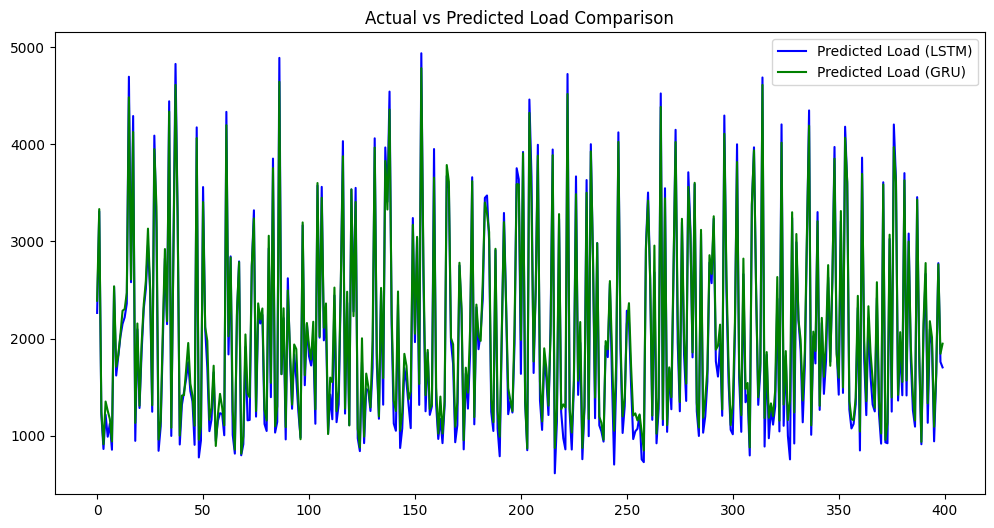

In [28]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
#plt.plot(scaler_target.inverse_transform(y_test), label='Actual Load', color='blue')
plt.plot(y_pred_lstm[:400], label='Predicted Load (LSTM)', color='blue', linestyle='-')
plt.plot(y_pred_gru[:400], label='Predicted Load (GRU)', color='green', linestyle='-')
plt.title('Actual vs Predicted Load Comparison')
plt.legend()
plt.show()


In [ ]:
# User Input Prediction Function
def get_user_input_and_predict():
    feature_names = list(features.columns)
    user_input = {}
    for feature in feature_names:
        user_input[feature] = float(input(f"Enter value for {feature}: "))
    
    dynamic_input = pd.DataFrame([user_input])
    dynamic_input_scaled = scaler_features.transform(dynamic_input)
    dynamic_input_reshaped = dynamic_input_scaled.reshape(1, 1, len(feature_names))
    predicted_scaled = model_gru.predict(dynamic_input_reshaped)
    predicted_load = scaler_target.inverse_transform(predicted_scaled)
    print(f'Predicted Load: {predicted_load[0][0]:.2f} KW')

# Run User Input Prediction
get_user_input_and_predict()
